# ADA Homework 2

In [297]:
# Import libraries
import requests
import pandas as pd
from bs4 import BeautifulSoup
%matplotlib inline

In [298]:
#URL we used to scrap Top Unsiversities and Times Higher Eduction web sites
tu_base_URL = 'https://www.topuniversities.com'
the_base_URL = 'http://www.timeshighereducation.com'

tu_rank_URL = '/sites/default/files/qs-rankings-data/357051.txt'
the_rank_URL = '/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json'

-----------------------

## Part 1
### Top Univerities Scraping
Analyzing the traffic on the API of the server, we realized that most of the information that we need lies in a file which we can find at the `rank_URL` ([link](https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt))

In [299]:
tu_r = requests.get(tu_base_URL + tu_rank_URL)

In [301]:
tu_json = tu_r.json()
tu_data = tu_json['data'][:200]

Here is a look at what one entry of the data looks like

In [302]:
tu_data[0]

{'cc': 'US',
 'core_id': '410',
 'country': 'United States',
 'guide': '<a href="/where-to-study/north-america/united-states/guide" class="guide-link" target="_blank">United States</a>',
 'logo': '<img src="https://www.topuniversities.com/sites/default/files/massachusetts-institute-of-technology-mit_410_small_0.jpg" alt="Massachusetts Institute of Technology (MIT)  Logo">',
 'nid': '294850',
 'rank_display': '1',
 'region': 'North America',
 'score': '100',
 'stars': '6',
 'title': 'Massachusetts Institute of Technology (MIT)',
 'url': '/universities/massachusetts-institute-technology-mit'}

Now we get the information we need for each university in the list, i.e. the name, country, region, rank and its url (in order to get the stats later)

In [303]:
tu_useful_data = []
for uni in tu_data:
    # We get the info we needed from the big json data file. We keep the name, country, region rank and url of each university
    tu_useful_data.append({'name': uni['title'], 'country': uni['country'], 'region': uni['region'],'rank': uni['rank_display'], 'url': uni['url']})

Now one entry looks like this

In [304]:
tu_useful_data[0]

{'country': 'United States',
 'name': 'Massachusetts Institute of Technology (MIT)',
 'rank': '1',
 'region': 'North America',
 'url': '/universities/massachusetts-institute-technology-mit'}

Here are some helper functions to treat the stats we can get on the individual university pages

In [305]:
def parse_int(s):
    '''Parses an int from a string that may contain commas or any letter. It retains the concatenation of all digits in the string'''
    return int(''.join(c for c in s if c.isdigit()))

In [306]:
def to_number(div):
    '''Returns what number is contained in a div (NaN if the object is None)'''
    if div is None:
        # This is a special case where the numbers are not on the page (for the NYU)
        return float('NaN')
    else:
        return parse_int(div.text)

In the next function we see that we use some div classes that correspond to statistics we want. These classes have been recovered with a Google Chrome plugin named SelectorGadget which lets you see the class for a given element in a webpage

In [307]:
def get_numbers_tu(url):
    req = requests.get(tu_base_URL + url)
    body = req.text
    soup = BeautifulSoup(body, 'html.parser')

    # The names that we want in our DataFrame
    names = ['staff_tot', 'staff_int', 'student_tot', 'student_int']
    # The div classes for each statistic we want
    div_classes = ['.total .text .number', '.inter .text .number', '.student .number', '.inter .progress-bar-info .number']
    numbers = {}
    
    for i in range(len(div_classes)):
        numbers[names[i]] = to_number(soup.select_one(div_classes[i]))
        
    return numbers

We will show how we operate on the first university in the ranking

In [308]:
cop = tu_useful_data.copy()

In [309]:
cop[0]

{'country': 'United States',
 'name': 'Massachusetts Institute of Technology (MIT)',
 'rank': '1',
 'region': 'North America',
 'url': '/universities/massachusetts-institute-technology-mit'}

In [310]:
get_numbers_tu(cop[0]['url'])

{'staff_int': 1679,
 'staff_tot': 2982,
 'student_int': 3717,
 'student_tot': 11067}

We can put everything in the current line of the `cop` with the method `update`

In [311]:
cop[0].update(get_numbers_tu(cop[0]['url']))
cop[0]

{'country': 'United States',
 'name': 'Massachusetts Institute of Technology (MIT)',
 'rank': '1',
 'region': 'North America',
 'staff_int': 1679,
 'staff_tot': 2982,
 'student_int': 3717,
 'student_tot': 11067,
 'url': '/universities/massachusetts-institute-technology-mit'}

__Warning__ the next step takes quite some time as it opens 200 requests

Now we do this for every university in our data

In [312]:
for i in range(len(tu_useful_data)):
    tu_useful_data[i].update(get_numbers_tu(tu_useful_data[i]['url']))

We get rid off the url and we transform the data into a `DataFrame`

In [313]:
ranking_tu = pd.DataFrame(tu_useful_data).drop('url', axis=1)
ranking_tu.head(12)

,country,name,rank,region,staff_int,staff_tot,student_int,student_tot
0,United States,Massachusetts Institute of Technology (MIT),1,North America,1679.0,2982.0,3717.0,11067.0
1,United States,Stanford University,2,North America,2042.0,4285.0,3611.0,15878.0
2,United States,Harvard University,3,North America,1311.0,4350.0,5266.0,22429.0
3,United States,California Institute of Technology (Caltech),4,North America,350.0,953.0,647.0,2255.0
4,United Kingdom,University of Cambridge,5,Europe,2278.0,5490.0,6699.0,18770.0
5,United Kingdom,University of Oxford,6,Europe,2964.0,6750.0,7353.0,19720.0
6,United Kingdom,UCL (University College London),7,Europe,2554.0,6345.0,14854.0,31080.0
7,United Kingdom,Imperial College London,8,Europe,2071.0,3930.0,8746.0,16090.0
8,United States,University of Chicago,9,North America,635.0,2449.0,3379.0,13557.0
9,Switzerland,ETH Zurich - Swiss Federal Institute of Techno...,10,Europe,1886.0,2477.0,7563.0,19815.0


Saving for later use without having to recompute everything

In [314]:
ranking_tu.to_csv('topuniversities.csv', encoding='utf-8', index=False)

In [315]:
ranking_tu = pd.read_csv('topuniversities.csv');

### Top Universities Data Wrangling 

#### a) & b)

Transforming the rank into an `int` (which means getting rid of the = when ties occured but this works as well without it)

In [316]:
ranking_tu['rank'] = ranking_tu['rank'].map(parse_int)

Computing the required stats

In [317]:
ranking_tu['student_rat'] = ranking_tu['student_int'] / ranking_tu['student_tot']
ranking_tu['student_staff_rat'] = ranking_tu['student_tot'] / ranking_tu['staff_tot']

Sorting the `DataFrame` to show the best university in terms of the ratio of number of students to number of staff

In [318]:
ranking_tu.sort_values(['student_staff_rat']).head(3)

,country,name,rank,region,staff_int,staff_tot,student_int,student_tot,student_rat,student_staff_rat
3,United States,California Institute of Technology (Caltech),4,North America,350.0,953.0,647.0,2255.0,0.286918,2.366212
15,United States,Yale University,16,North America,1708.0,4940.0,2469.0,12402.0,0.199081,2.510526
5,United Kingdom,University of Oxford,6,Europe,2964.0,6750.0,7353.0,19720.0,0.372870,2.921481


Sorting the `DataFrame` to show the best university in terms of the ratio of international to total number of students

In [319]:
ranking_tu.sort_values(['student_rat'], ascending=False).head(3)

,country,name,rank,region,staff_int,staff_tot,student_int,student_tot,student_rat,student_staff_rat
34,United Kingdom,London School of Economics and Political Scien...,35,Europe,687.0,1088.0,6748.0,9760.0,0.691393,8.970588
11,Switzerland,Ecole Polytechnique Fédérale de Lausanne (EPFL),12,Europe,1300.0,1695.0,5896.0,10343.0,0.570047,6.102065
7,United Kingdom,Imperial College London,8,Europe,2071.0,3930.0,8746.0,16090.0,0.543567,4.094148



#### c) & d)

We process the data through a groupby over `region` and `country`. when then take the mean and select what we want from our functon `bar_plot`

In [320]:
ranking_tu_by_region = ranking_tu.groupby(['region']).mean()
ranking_tu_by_country = ranking_tu.groupby(['country']).mean()

In [321]:
import seaborn as sns
import matplotlib.pyplot as plt

Helper function to plot a given column (`y`) of a given `DataFrame` (`data`)

In [322]:
def bar_plot(data, title, y, x='', rotation=0, sort=False, ascending=True):
    fig, ax = plt.subplots()
    ax.set_title(title, fontsize=15, fontweight='bold')
    if sort:
        ax = sns.barplot(data.sort_values([y], ascending=ascending)[y].keys(), data.sort_values([y], ascending=ascending)[y], ax=ax)
    else:
        ax = sns.barplot(data[y].keys(), data[y], ax=ax)
    locs, labels = plt.xticks()
    ax.set(xlabel=x, ylabel=y)
    plt.setp(labels, rotation=rotation)
    plt.show()

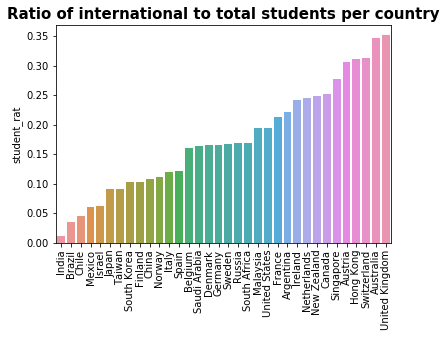

In [323]:
bar_plot(ranking_tu_by_country, 'Ratio of international to total students per country', 'student_rat', rotation=90, sort = True)

We see clearly that in India there are not a lot of international students compare to the other countries. But it's important to keep in mind that our graph only includes the top 200 universities. And for exemple in india we only juged the number of international students according to only 3 different indian universities. The average of international student in india could be bigger. Even though we don't think so since there is a correlation between number of international student and ranking of the school. see task 3 below

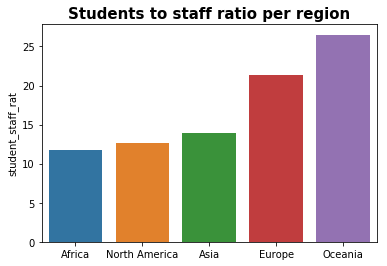

In [324]:
bar_plot(ranking_the_by_region, 'Students to staff ratio per region', 'student_staff_rat', sort= True)

The overall results shows us that Oceania are the worst and Africa the best. But here again, it's just from the top 200 universties.

---------------------

## Part 2

### Times Higher Eduction Scarping

We will restart what we have done for the other ranking

In [325]:
the_r = requests.get(the_base_URL + the_rank_URL)

In [326]:
type(the_r.json())

dict

In [327]:
the_json = the_r.json()
the_data = the_json['data'][:200]

Taking a peek at what the data looks like for each university. Here we can see that we already get the stats we want

In [328]:
the_data[0]

{'aliases': 'University of Oxford',
 'location': 'United Kingdom',
 'member_level': '0',
 'name': 'University of Oxford',
 'nid': 468,
 'rank': '1',
 'rank_order': '10',
 'record_type': 'master_account',
 'scores_citations': '99.1',
 'scores_citations_rank': '15',
 'scores_industry_income': '63.7',
 'scores_industry_income_rank': '169',
 'scores_international_outlook': '95.0',
 'scores_international_outlook_rank': '24',
 'scores_overall': '94.3',
 'scores_overall_rank': '10',
 'scores_research': '99.5',
 'scores_research_rank': '1',
 'scores_teaching': '86.7',
 'scores_teaching_rank': '5',
 'stats_female_male_ratio': '46 : 54',
 'stats_number_students': '20,409',
 'stats_pc_intl_students': '38%',
 'stats_student_staff_ratio': '11.2',
 'subjects_offered': 'Archaeology,Art, Performing Arts & Design,Biological Sciences,Business & Management,Chemical Engineering,Chemistry,Civil Engineering,Computer Science,Economics & Econometrics,Electrical & Electronic Engineering,General Engineering,Geo

Keeping the data we need just as before, but we can get the stats directly now, so we no longer need the url

In [329]:
the_useful_data = []
for uni in the_data:
    the_useful_data.append({'name': uni['name'], 'rank': uni['rank'], 'country': uni['location'], 'student_tot': uni['stats_number_students'], 'student_staff_rat': float(uni['stats_student_staff_ratio']), 'student_rat': parse_int(uni['stats_pc_intl_students']) / 100})

Transforming the data into a nice `DataFrame`

In [330]:
ranking_the = pd.DataFrame(the_useful_data)
ranking_the['rank'] = ranking_the['rank'].map(parse_int)
ranking_the.head()

,country,name,rank,student_rat,student_staff_rat,student_tot
0,United Kingdom,University of Oxford,1,0.38,11.2,"20,409"
1,United Kingdom,University of Cambridge,2,0.35,10.9,"18,389"
2,United States,California Institute of Technology,3,0.27,6.5,"2,209"
3,United States,Stanford University,3,0.22,7.5,"15,845"
4,United States,Massachusetts Institute of Technology,5,0.34,8.7,"11,177"


Saving the `DataFrame` for later use

In [331]:
ranking_the.to_csv('timeshighereducation.csv', encoding='utf-8', index=False)

### Data wrangling for Times Higher Eductions

Since the data region is missing in the first ranking, we proceed as follow
From the first ranking we generate a `dict` from the country to the region that we applied to the second ranking

In [332]:
c = ranking_tu[['country','region']].drop_duplicates()
c = c.set_index("country")
map_country_region = c.T.to_dict(orient='records')[0]

#Handeling special case
map_country_region.update({"Luxembourg":"Europe","Russian Federation":"Europe"})
ranking_the["region"] = ranking_the["country"].map(map_country_region)

#### a) & b)

Since we already have the value of student to staff ratio i.e. `student_staff_rat` , and the percentage of international student. i.e.`student_rat`. We just have to sort them to find the best one.

In [333]:
ranking_the.sort_values('student_staff_rat', ascending = True).head(3)

,country,name,rank,student_rat,student_staff_rat,student_tot,region
105,United States,Vanderbilt University,105,0.13,3.3,"12,011",North America
109,Denmark,University of Copenhagen,109,0.14,4.1,"30,395",Europe
12,United States,Johns Hopkins University,13,0.24,4.3,"15,498",North America


Curiously, we notice that the worst 5 of this ranking implies just german universities (But it's ok since they are on the top 200):

In [334]:
ranking_the.sort_values('student_staff_rat', ascending = False).head()

,country,name,rank,student_rat,student_staff_rat,student_tot,region
99,Germany,University of Bonn,100,0.13,77.9,"35,619",Europe
124,Germany,University of Mannheim,125,0.16,74.5,"10,995",Europe
91,Germany,Technical University of Berlin,92,0.20,64.3,"22,390",Europe
163,Germany,University of Erlangen-Nuremberg,162,0.12,58.5,"38,730",Europe
78,Germany,RWTH Aachen University,79,0.18,57.7,"43,721",Europe


Now let's look at the top ranking concerning the percentage of international student

In [335]:
ranking_the.sort_values('student_rat', ascending = False).head(3)

,country,name,rank,student_rat,student_staff_rat,student_tot,region
24,United Kingdom,London School of Economics and Political Science,25,0.71,12.2,"10,065",Europe
178,Luxembourg,University of Luxembourg,179,0.57,14.6,"4,969",Europe
37,Switzerland,École Polytechnique Fédérale de Lausanne,38,0.55,11.2,"9,928",Europe


Nicely we see EPFL at the 3rd position

#### c) & d)

As before

In [336]:
ranking_the_by_region = ranking_the.groupby(['region']).mean()
ranking_the_by_country = ranking_the.groupby(['country']).mean()

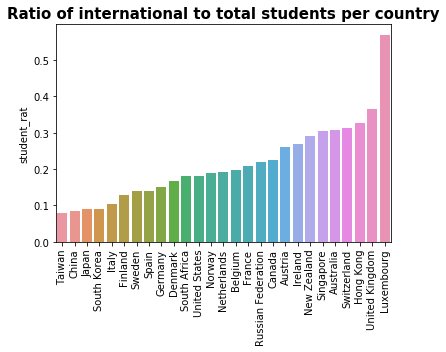

In [337]:
bar_plot(ranking_the_by_country, 'Ratio of international to total students per country', 'student_rat', rotation=90, sort=True)

At first glance we could think that this graph is very different from the other. This is just due to Luxembourg that  enters in the top 200. Luxembourg is well known to be a small country and thus would be more likely to have a high ratio of international student. This rescale the student_rat axis and made the other countries relativly small and not having a big difference between them. 

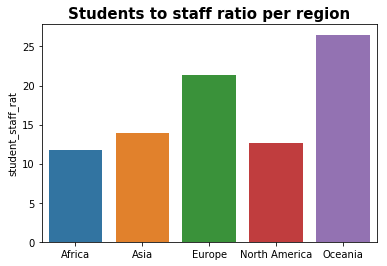

In [338]:
bar_plot(ranking_the_by_region, 'Students to staff ratio per region', 'student_staff_rat')

----------------------

### Part 3

#### Merging Top Universities and Times Higher Education

Here, we declare some usefull function in order to merge the two dataframe according to the name

In [339]:
import re

def keep_letters(s):
    return ''.join(c for c in s if c.isalpha())

# Here is a map to handle the special case of our
def treat_special_cases(name):
    equiv = {
        'vrijeuniversiteitbrussel': 'universitélibredebruxelles',
        'universitédemontréal': 'universityofmontreal',
        'ecolepolytechnique': 'écolepolytechnique',
        'universitépierreetmariecurie': 'pierreandmariecurieuniversity',
        'ludwigmaximiliansuniversitätmünchen': 'lmumunich',
        'kitkarlsruheinstituteoftechnology': 'karlsruheinstituteoftechnology',
        'humboldtuniversitätzuberlin': 'humboldtuniversityofberlin',
        'freieuniversitaetberlin': 'freeuniversityofberlin',
        'technischeuniversitätberlin': 'technicaluniversityofberlin',
        'eberhardkarlsuniversitättübingen': 'universityoftübingen',
        'albertludwigsuniversitaetfreiburg': 'universityoffreiburg',
        'trinitycollegedublinuniversityofdublin': 'trinitycollegedublin',
        'scuolasuperioresantannapisadistudiuniversitariediperfezionamento': 'scuolasuperioresantanna',
        'wageningenuniversity': 'wageningenuniversityresearch',
        'kaistkoreaadvancedinstituteofsciencetechnology': 'koreaadvancedinstituteofscienceandtechnology',
        'universitatautònomadebarcelona': 'autonomousuniversityofbarcelona',
        'ethzurichswissfederalinstituteoftechnology': 'ethzurichswissfederalinstituteoftechnologyzurich',
        'ecolepolytechniquefédéraledelausanne': 'écolepolytechniquefédéraledelausanne',
        'ucl': 'universitycollegelondon',
        'universityofnorthcarolinachapelhill': 'universityofnorthcarolinaatchapelhill'
    }
    try:
        return equiv[name]
    except:
        return name

def norm_name(name):
    '''Sets the name to a standard for an easier matching'''
    name = name.lower() # Lowercase
    name = re.sub('(\().*?(\))', '', name) # Gets rid of things in brackets
    name = keep_letters(name) # Only keep alphas in string
    name = re.sub('the', '', name) # Deletes 'the' from the name 
    name = treat_special_cases(name) # Special cases we had to find by hand
    return name
    
norm_name('The Ecole - Polytéchnique (EPFL)')


'ecolepolytéchnique'

Normalizing and merging

In [340]:
ranking_tu['norm_name'] = ranking_tu.name.map(norm_name)
ranking_the['norm_name'] = ranking_the.name.map(norm_name)
ranking_merge_outer = pd.merge(ranking_tu, ranking_the, how='outer', on=['norm_name','region'], suffixes=('_tu', '_the'))[['country_tu', 'name_tu', 'norm_name', 'country_the', 'name_the']]

In [352]:
# Universtities that could not find any match
still_null = ranking_merge_outer[ranking_merge_outer.isnull().any(axis=1)]

still_null = still_null.sort_values(['country_tu', 'country_the'])

In [353]:
print('Number of schools that were not in both tables: {s}'.format(s=still_null.shape[0]))

Number of schools that were not in both tables: 80


In [362]:
ranking_merge = pd.merge(
    ranking_tu,
    ranking_the,
    how='outer',
    on=['norm_name', 'country', 'region'],
    suffixes=('_tu', '_the')
)[['norm_name',"name_tu", "name_the", 'country', 'region', 'rank_tu', 'rank_the']]

Here we present the merged `dataframe` with a combined rank `rank_mean` in which we compute the mean of both of the rank. To be as fair as possible, when a university was not in one of the rank and thus add `nan` as the rank, we set up this `nan` at 201. 

In [374]:
ranking_merge['rank_tu'] = ranking_merge.rank_tu.fillna(201)
ranking_merge['rank_the'] = ranking_merge.rank_the.fillna(201)

ranking_merge['rank_mean'] = ranking_merge[['rank_tu', 'rank_the']].mean(axis=1)
ranking_merge.sort_values('rank_mean').iloc[190:192]

,norm_name,name_tu,name_the,country,region,rank_tu,rank_the,rank_mean
154,hanyanguniversity,Hanyang University,NaN,South Korea,Asia,155.0,201.0,178.0
215,tudresden,NaN,TU Dresden,Germany,Europe,201.0,155.0,178.0


We finally create a dict to change from the attribut `norm_name` to a nice name attibut. This is done by mapping back from the `norm_name` attributes to the name that were in one of the `name_tu` or `name_the` attributes.

In [368]:
name_only_the = ranking_merge[ranking_merge["name_tu"].isnull()].set_index("norm_name")["name_the"]
name_only_tu = ranking_merge[ranking_merge["name_tu"].notnull()].set_index("norm_name")["name_tu"]

In [369]:
a = name_only_the.to_dict()
a.update(name_only_tu.to_dict())

In [370]:
final_ranking = ranking_merge.copy()
final_ranking['name'] = final_ranking["norm_name"].map(a)
final_ranking = final_ranking.drop(["norm_name", "name_tu","name_the"], axis=1).sort_values("rank_mean")

In [371]:
final_ranking.set_index("name")

,country,region,rank_tu,rank_the,rank_mean
name,,,,,
Stanford University,United States,North America,2.0,3.0,2.5
Massachusetts Institute of Technology (MIT),United States,North America,1.0,5.0,3.0
California Institute of Technology (Caltech),United States,North America,4.0,3.0,3.5
University of Cambridge,United Kingdom,Europe,5.0,2.0,3.5
University of Oxford,United Kingdom,Europe,6.0,1.0,3.5
Harvard University,United States,North America,3.0,6.0,4.5
Imperial College London,United Kingdom,Europe,8.0,8.0,8.0
University of Chicago,United States,North America,9.0,9.0,9.0
ETH Zurich - Swiss Federal Institute of Technology,Switzerland,Europe,10.0,10.0,10.0


## Part 4
### Analysis of our data

To start with this part, we thought that it could be interesting to look at the top 100 unis of both rankings and focus on the part that the USA and UK take.

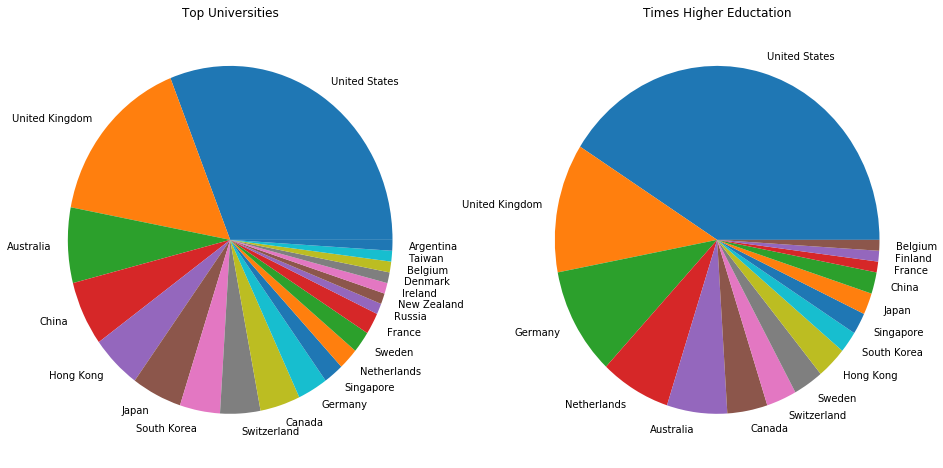

In [351]:
country_count_the = ranking_the.iloc[:100].groupby("country")['name'].count().sort_values(ascending=False).rename("")
country_count_tu = ranking_tu.iloc[:100].groupby("country")['name'].count().sort_values(ascending=False).rename("")
#country_count_the.head(10).plot.pie()

f, ax = plt.subplots(1,2, figsize=(16,8))

country_count_tu.plot(ax=ax[0],kind='pie',title="Top Universities")
country_count_the.plot(ax=ax[1],kind='pie',title="Times Higher Eductation")

plt.show()

Indeed, although it is a pretty obvious finding, the pies help us to see how both US and UK dominate the top ranks of the worldwide university rankings.

Now focusing on correlation,

In order to plot multiple linear regressions and highlight the correlation, a method is created :

In [375]:
# Input : two pd.Series to compare
# Plot a linear regression with the correlation factor
def plot_regression(data_x, data_y, title, x_reverse=False) :
    
    data_x= data_x.sort_values(ascending= not x_reverse)
    corr = ' (correlation factor: '+ str(round(data_y.corr(data_x),2)) + ')'
    title += str(corr)
    fig, ax = plt.subplots()
    ax= sns.regplot(data_x,data_y)
    ax.set_title(title, fontsize=14)
    plt.show()
    

Let's compare the behaviour of the rank of universities compared to their international student ratio for the Top Universities ranking :

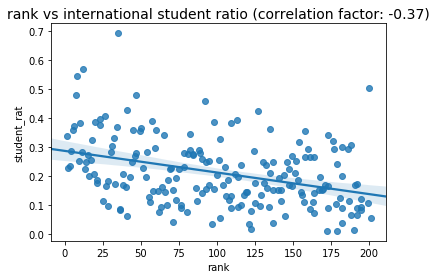

In [376]:
plot_regression(ranking_tu['rank'],ranking_tu['student_rat'],'rank vs international student ratio') 

It seems that the higher the international student ratio is, the better the uni is ranked. However, the correlation is not really close to 1, which means that this hypothesis is not the most interesting one, although it highlights a light tendency.

However, the relation is less clear in the second ranking THE. A really light tendency can still be seen :

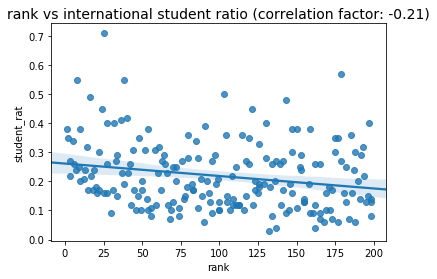

In [377]:
plot_regression(ranking_the['rank'],ranking_the['student_rat'],'rank vs international student ratio') 

Now comparing student-to staff ratio versus rank, we could expect that the higher the ratio is, the better ranked the uni could be, since the students would have more resources through a greater amount of staff employees, or that the higher the ranking, the more funds the uni have and can therefore employ more staff :

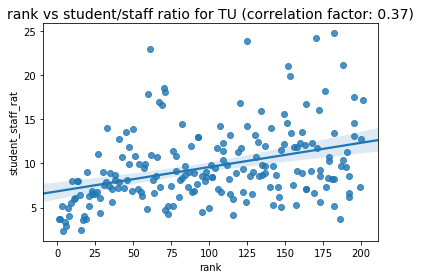

In [378]:
plot_regression(ranking_tu['rank'],ranking_tu['student_staff_rat'],'rank vs student/staff ratio for TU') 

Indeed it seems to be the case that better universities tend to have a lower student/staff ratio. This could be explained partly with both hypothesis stated just before. Another hypothesis could be that the TU ranking bases itself on the student/staff ratio as one of the ranking criteria.

Looking at the THE ranking, the correlation is quite smaller and no real hypothesis and conclusions can be made. This could emphasize our hypothesis stated above, where opposite to TU, THE ranks according to criteria not closely related to the student/staff ratio.

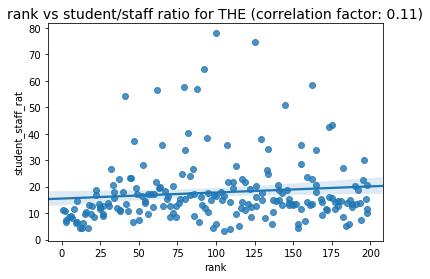

In [379]:
plot_regression(ranking_the['rank'],ranking_the['student_staff_rat'],'rank vs student/staff ratio for THE') 

We can also take a look on the universities rank correlation  between the two rankings : 

In [380]:
correlation_rank = final_ranking.drop('rank_mean',axis=1).corr()
correlation_rank

,rank_tu,rank_the
rank_tu,1.000000,0.673972
rank_the,0.673972,1.000000


Finally, if we look at the correlation between the ranks of the two different rankings, we can see that the value is around 0,7. This value is indeed quite high, which might be reassuring on the professionalism of both ranking authorities, making at the same time the process of considering different rankings more relevant, since those rankings share a certain amount of results.

## Part 5

As seen before with the final ranking, we decided to give the same weight to both THE and TU rankings by just inserting a column in the merged DataFrame containing the **mean rank**. There is for us no particular reason to give one ranking more importance than the other. In fact, one should look at both and compare the rankings, taking into account the different characteristics and approaches than the respective authorities took in order to produce their ranking.

The final combined rank can be seen below :

In [382]:
optimal_ranking = final_ranking[:200].copy()
optimal_ranking['combined_rank'] = range(1,201)
opt = optimal_ranking[['name']].set_index(optimal_ranking['combined_rank'])
opt.head(20)

,name
combined_rank,
1,Stanford University
2,Massachusetts Institute of Technology (MIT)
3,California Institute of Technology (Caltech)
4,University of Cambridge
5,University of Oxford
6,Harvard University
7,Imperial College London
8,University of Chicago
9,ETH Zurich - Swiss Federal Institute of Techno...
